# Number of Days Before Adoption

In [1]:
!pip install catboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
### loading in shelter data
shelter_data = pd.read_csv('./Animal_Shelter_Data.csv')
shelter_data.head(3)

,Name,Type,Breed,Color,Sex,Size,Date Of Birth,Impound Number,Kennel Number,Animal ID,...,Intake Subtype,Outcome Type,Outcome Subtype,Intake Condition,Outcome Condition,Intake Jurisdiction,Outcome Jurisdiction,Outcome Zip Code,Location,Count
0,RAZOR,DOG,BOSTON TERRIER,BLACK/WHITE,Neutered,SMALL,10/29/2009,K22-043412,TRUCK,A396382,...,FIELD,RETURN TO OWNER,FLD_IDTAG,UNKNOWN,HEALTHY,SANTA ROSA,SANTA ROSA,95404.0,"95404(38.43807, -122.71247)",1
1,NaN,OTHER,PIGEON,GRAY/WHITE,Unknown,SMALL,NaN,K23-044095,TRUCK,A416206,...,FIELD,EUTHANIZE,INJ SEVERE,UNKNOWN,HEALTHY,SANTA ROSA,NaN,NaN,NaN,1
2,MAX,DOG,BORDER COLLIE,BLACK/TRICOLOR,Neutered,MED,03/10/2020,K23-044090,DS80,A399488,...,FIELD,RETURN TO OWNER,OVER THE COUNTER_CALL,UNKNOWN,PENDING,COUNTY,COUNTY,95472.0,"95472(38.40179, -122.82512)",1


In [4]:
shelter_data.columns

Index(['Name', 'Type', 'Breed', 'Color', 'Sex', 'Size', 'Date Of Birth',
       'Impound Number', 'Kennel Number', 'Animal ID', 'Intake Date',
       'Outcome Date', 'Days in Shelter', 'Intake Type', 'Intake Subtype',
       'Outcome Type', 'Outcome Subtype', 'Intake Condition',
       'Outcome Condition', 'Intake Jurisdiction', 'Outcome Jurisdiction',
       'Outcome Zip Code', 'Location', 'Count'],
      dtype='object')

In [5]:
### filtering on animals that are ultimately adopted
adopted_all = shelter_data[shelter_data['Outcome Type'] == 'ADOPTION']
adopted_all.head(3)

,Name,Type,Breed,Color,Sex,Size,Date Of Birth,Impound Number,Kennel Number,Animal ID,...,Intake Subtype,Outcome Type,Outcome Subtype,Intake Condition,Outcome Condition,Intake Jurisdiction,Outcome Jurisdiction,Outcome Zip Code,Location,Count
10,*TABITHA,CAT,DOMESTIC SH,BLACK,Spayed,KITTN,07/14/2022,K22-042942,LOBBY,A413866,...,OVER THE COUNTER,ADOPTION,WALKIN,HEALTHY,HEALTHY,SANTA ROSA,COUNTY,95589.0,"95589(40.06054, -123.96838)",1
13,*PEPPER,CAT,DOMESTIC SH,BLACK/WHITE,Neutered,KITTN,08/29/2022,K22-042992,CA02,A413965,...,OVER THE COUNTER,ADOPTION,WALKIN,HEALTHY,HEALTHY,COUNTY,SANTA ROSA,95403.0,"95403(38.51311, -122.75502)",1
18,SIR DUNCAN NEPAL,DOG,NEWFOUNDLAND/MIX,BLACK/WHITE,Neutered,X-LRG,08/07/2017,K20-036379,DS82,A399409,...,OVER THE COUNTER,ADOPTION,REFERRAL-F,UNKNOWN,PENDING,SANTA ROSA,*PETALUMA,94954.0,"94954(38.2581, -122.63753)",1


In [6]:
### keeping only relevant columns
adopted = adopted_all[['Type', 'Breed', 'Color', 'Sex', 'Size', 'Date Of Birth', 'Intake Date','Days in Shelter', 
                       'Intake Type', 'Intake Subtype', 'Intake Condition', 'Intake Jurisdiction']]
adopted = adopted.reset_index(drop=True)
adopted.head(3)

,Type,Breed,Color,Sex,Size,Date Of Birth,Intake Date,Days in Shelter,Intake Type,Intake Subtype,Intake Condition,Intake Jurisdiction
0,CAT,DOMESTIC SH,BLACK,Spayed,KITTN,07/14/2022,10/25/2022,63,STRAY,OVER THE COUNTER,HEALTHY,SANTA ROSA
1,CAT,DOMESTIC SH,BLACK/WHITE,Neutered,KITTN,08/29/2022,10/29/2022,59,STRAY,OVER THE COUNTER,HEALTHY,COUNTY
2,DOG,NEWFOUNDLAND/MIX,BLACK/WHITE,Neutered,X-LRG,08/07/2017,08/07/2020,20,OWNER SURRENDER,OVER THE COUNTER,UNKNOWN,SANTA ROSA


In [7]:
### creating a feature for animal age at intake time
adopted = adopted[~adopted['Date Of Birth'].isna()]
adopted = adopted.reset_index(drop=True)
adopted['age'] = (pd.to_datetime(adopted['Intake Date'], format='%m/%d/%Y') - pd.to_datetime(adopted['Date Of Birth'], 
                                                                                            format='%m/%d/%Y')).dt.days
adopted = adopted.drop(columns=['Intake Date', 'Date Of Birth'])
adopted = adopted.fillna('nan')
adopted.head(3)

,Type,Breed,Color,Sex,Size,Days in Shelter,Intake Type,Intake Subtype,Intake Condition,Intake Jurisdiction,age
0,CAT,DOMESTIC SH,BLACK,Spayed,KITTN,63,STRAY,OVER THE COUNTER,HEALTHY,SANTA ROSA,103
1,CAT,DOMESTIC SH,BLACK/WHITE,Neutered,KITTN,59,STRAY,OVER THE COUNTER,HEALTHY,COUNTY,61
2,DOG,NEWFOUNDLAND/MIX,BLACK/WHITE,Neutered,X-LRG,20,OWNER SURRENDER,OVER THE COUNTER,UNKNOWN,SANTA ROSA,1096


In [8]:
test = adopted[adopted['Days in Shelter'] <= 200]

In [9]:
### test train split

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(test.drop('Days in Shelter', axis=1), 
                                                    test['Days in Shelter'], test_size=0.2, random_state=42)

In [10]:
# Creating and training a CatBoost regression model
model = CatBoostRegressor(cat_features=[0, 1, 2, 3, 4, 5, 6, 7, 8], loss_function='MAE', verbose=500)

parameters = {'depth'         : [3, 5, 7, 9],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations'    : [500, 1000, 1500]
                 }

grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2)
grid.fit(X_train, y_train)

0:	learn: 18.9144663	total: 48.6ms	remaining: 24.3s
499:	learn: 14.8969561	total: 768ms	remaining: 0us
0:	learn: 18.5923534	total: 3.06ms	remaining: 1.53s
499:	learn: 14.9095096	total: 753ms	remaining: 0us
0:	learn: 18.7387419	total: 3.24ms	remaining: 1.62s
499:	learn: 13.9361536	total: 731ms	remaining: 0us
0:	learn: 18.4462880	total: 1.98ms	remaining: 987ms
499:	learn: 14.0318902	total: 729ms	remaining: 0us
0:	learn: 18.5245729	total: 2.02ms	remaining: 1s
499:	learn: 13.3764722	total: 709ms	remaining: 0us
0:	learn: 18.2652333	total: 2.62ms	remaining: 1.31s
499:	learn: 13.5925261	total: 706ms	remaining: 0us
0:	learn: 18.9144663	total: 2.44ms	remaining: 2.44s
500:	learn: 14.8951647	total: 740ms	remaining: 737ms
999:	learn: 14.4531511	total: 1.46s	remaining: 0us
0:	learn: 18.5923534	total: 1.95ms	remaining: 1.94s
500:	learn: 14.9087812	total: 702ms	remaining: 700ms
999:	learn: 14.5433426	total: 1.4s	remaining: 0us
0:	learn: 18.7387419	total: 2.47ms	remaining: 2.47s
500:	learn: 13.9355895

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostRegressor object at 0x7efc20d41420>,
             param_grid={'depth': [3, 5, 7, 9], 'iterations': [500, 1000, 1500],
                         'learning_rate': [0.01, 0.05, 0.1]})

In [11]:
grid.best_params_

{'depth': 9, 'iterations': 1500, 'learning_rate': 0.05}

In [12]:
model = CatBoostRegressor(cat_features=[0, 1, 2, 3, 4, 5, 6, 7, 8], loss_function='MAE', verbose=500,
                         depth=9, iterations=1500, learning_rate=0.05)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

0:	learn: 18.5028133	total: 23ms	remaining: 34.5s
500:	learn: 10.1872601	total: 8.27s	remaining: 16.5s
1000:	learn: 8.7589867	total: 16.6s	remaining: 8.25s
1499:	learn: 8.0344979	total: 24.8s	remaining: 0us


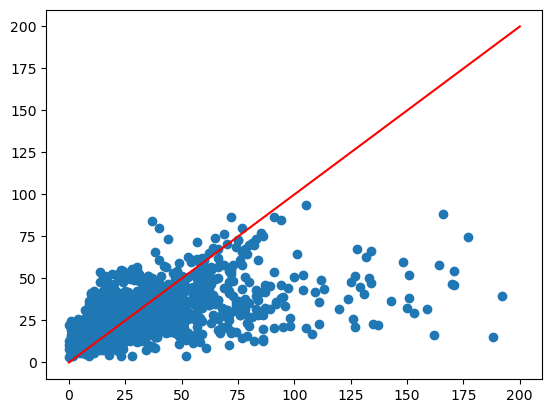

In [13]:
x = np.linspace(0, 200, 100)
y = x

plt.plot(x, y, color='red');
plt.scatter(x=y_test, y=predictions);
plt.show()

In [14]:
feature_importance = model.get_feature_importance()

# Create a dictionary to store the feature importance scores with their corresponding feature names
feature_importance_dict = dict(zip(X_train.columns, feature_importance))

# Sort the features by their importance scores in descending order and get the top N features
n = 10  # number of top features to select
top_features = sorted(feature_importance_dict, key=feature_importance_dict.get, reverse=True)[:n]

# Print the top N features
print(f"Top {n} Features:")
for feature in top_features:
    print(f"{feature}: {feature_importance_dict[feature]}")

Top 10 Features:
age: 17.37831980781531
Color: 13.384210745426294
Size: 10.54400616631359
Intake Condition: 10.404406589511911
Breed: 9.5344276492955
Intake Type: 9.36074959502394
Intake Subtype: 8.947070989951765
Intake Jurisdiction: 7.1475461122126
Sex: 6.766996833848723
Type: 6.532265510600237
